In [1]:
%pip install -q python-dotenv langchain-openai langgraph langchain_chroma
%pip install -qU pypdf langchain-community langchain-text-splitters ython-dotenv
%pip install -q "unstructured[md]" nltk

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement ython-dotenv (from versions: none)

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for ython-dotenv


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import os
from dotenv import load_dotenv
load_dotenv('../.env')

python-dotenv could not parse statement starting at line 11
python-dotenv could not parse statement starting at line 13
python-dotenv could not parse statement starting at line 14
python-dotenv could not parse statement starting at line 15
python-dotenv could not parse statement starting at line 16
python-dotenv could not parse statement starting at line 18
python-dotenv could not parse statement starting at line 19
python-dotenv could not parse statement starting at line 20


True

In [4]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings(model='text-embedding-3-large')

vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name = 'income_tax_collection',
    persist_directory='./income_tax_collection'
)
retriever = vector_store.as_retriever(search_kwargs={'k': 3})

In [5]:
query = "거주자의 연봉 5천만원 소득세는 얼마인가"
retriever.invoke(query)

[Document(id='efc91b11-220c-458e-addf-13dd02fa0926', metadata={'source': './documents/income_tax.txt'}, page_content='5년 이하: 30만원 → 납입연수\n5년 초과 10년 이하: 150만원 + 50만원 × (납입연수 - 5년)\n10년 초과 20년 이하: 400만원 + 80만원 × (납입연수 - 10년)\n20년 초과: 1,200만원 + 120만원 × (납입연수 - 20년)\n\n② 직장근로자 초과관세환급금을 분배하여 지급받는 경우 세액의 계산 방법 등 필요한 사항은 대통령령으로 정한다. \n<대통령 2014. 12. 23.>\n<전문개정 2009. 12. 31.>\n제64조(부동산매매업자에 대한 세액 계산의 특례)\n1) 대통령령으로 정하는 부동산매매업(이하 “부동산매매업”이라 한다)을 영위하는 거주자가 이하 “부동산매매업자”라 한다)로서 종합소득세법에 제104조제1항제1호(본항을 포함한다) 및 제103조 또는 같은 조 제7항 각 호의 어느 하나에 해당하는 자산의 매매자익(이하 “주택등매매차익”이라 한다)이 있는 자의 종합소득 산출세액은 다음 각 호의 세액 중 많은 것으로 한다. \n<개정 2014. 12. 23., 2017. 12. 19., 2020. 12. 29.>\n1. 종합소득 산출세액\n\n다음 각 목에 따른 세액의 합계액\n  가. 주택등매매차익에 따른 세율을 적용하여 산출한 세액의 합계액\n  나. 종합소득세법 제55조에 따라 주택등매매차익에 대한 개별세액을 공제한 금액을 과세표준으로 하고 이에 제55조에 따른 세율을 적용하여 산출세액'),
 Document(id='37ad216c-7206-469b-be34-d7ee06a2561f', metadata={'source': './documents/income_tax.txt'}, page_content='5년 이하: 30만원 → 납입연수\n5년 초과 10년 이하: 150만원 + 50만원 × (납입연수 - 5년)

In [6]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

class AgentState(TypedDict):
    query: str
    context: str
    answer: str
    retry_count: int
    max_retries: int

In [7]:
def retrieve_node(state: AgentState) -> AgentState:
    """
    사용자의 질문에 기반하여 벡터 스토어에서 관련 문서를 검색합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 검색된 문서가 추가된 state를 반환합니다.
    """
    query = state['query']
    docs = retriever.invoke(query)
    return {'context': docs}

In [8]:
from langchain import hub
from langchain_openai import ChatOpenAI

# 허브에서 RAG 프롬프트를 가져옵니다
generate_prompt = hub.pull("rlm/rag-prompt")

# 지정된 매개변수로 언어 모델을 초기화합니다
generate_llm = ChatOpenAI(model='gpt-4o', max_completion_tokens=100)

def generate(state: AgentState) -> AgentState:
    """
    주어진 state를 기반으로 RAG 체인을 사용하여 응답을 생성합니다.

    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 생성된 응답을 포함하는 state를 반환합니다.
    """
    # state에서 컨텍스트와 쿼리를 추출합니다
    context = state['context']
    query = state['query']
    
    # 작업 체인을 생성합니다: 먼저 프롬프트를 검색하고, 그 다음 응답을 생성합니다
    rag_chain = generate_prompt | generate_llm
    
    # 쿼리와 컨텍스트로 체인을 호출하여 응답을 얻습니다
    response = rag_chain.invoke({'question': query, 'context': context})
    
    # 생성된 답변을 반환합니다
    return {'answer': response.content}

In [9]:
from langchain import hub
from typing import Literal

doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")

llm = ChatOpenAI(model='gpt-4o', max_completion_tokens=3000)

def check_doc_relevance(state: AgentState) -> Literal['relevant', 'irrelevant']:
    """
    주어진 state를 기반으로 문서의 관련성을 판단합니다.

    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state.

    Returns:
        Literal['relevant', 'irrelevant']: 문서가 관련성이 높으면 'relevant', 그렇지 않으면 'irrelevant'를 반환합니다.
    """
    query = state['query']
    context = state['context']

    doc_relevance_chain = doc_relevance_prompt | llm
    response = doc_relevance_chain.invoke({'question': query, 'documents': context})

    if response['Score'] == 1:
        # 2.3장과 다르게 `relevant`와 `irrelevant`를 반환합니다
        # node를 직접 지정하는 것보다 실제 판단 결과를 리턴하면서 해당 node의 재사용성을 높일 수 있습니다.
        return 'relevant'
    
    return 'irrelevant'

In [10]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser


rewrite_prompt = PromptTemplate.from_template(f"""
사용자의 질문을 보고, 우리의 웹검색에 용이하게 사용자의 질문을 수정해주세요 
                                         
질문: {{query}}
""")

def rewrite(state: AgentState) -> AgentState:
    """
    사용자의 질문을 사전을 참고하여 변경합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 변경된 질문을 포함하는 state를 반환합니다.
    """

    query = state['query']
    retry_count = state.get('retry_count', 0)

    rewrite_chain = rewrite_prompt | llm | StrOutputParser()

    response = rewrite_chain.invoke({'query': query})

    return {'query': response, 'retry_count': retry_count + 1}

In [ ]:
from langchain_community.tools import TavilySearchResults

tavily_search_tool = TavilySearchResults(
    max_results=3,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
)

def web_search(state: AgentState) -> AgentState:
    """
    주어진 state를 기반으로 웹 검색을 수행합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 웹 검색 결과가 추가된 state를 반환합니다.
    """
    query = state['query']
    results = tavily_search_tool.invoke(query)

    return {'context': results}
    # return {'context': results, 'retry_count': retry_count + 1}

C:\Users\bitcamp\AppData\Local\Temp\ipykernel_9600\1336542735.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search_tool = TavilySearchResults(


In [12]:
# 단일 conditional edge로 처리
def check_doc_relevance_and_route(state: AgentState) -> Literal['relevant', 'rewrite', 'web_search', 'end']:
    
    query = state['query']
    context = state['context']
    retry_count = state.get('retry_count', 0)

    doc_relevance_chain = doc_relevance_prompt | llm
    
    response = doc_relevance_chain.invoke({'question': query, 'documents': context})

    if response['Score'] == 1:
        return 'relevant'

    else:
        # 관련성이 없을 때 재시도 횟수에 따라 라우팅
        if retry_count == 0:
            return 'rewrite'
        elif retry_count <= 2:  # 1, 2번째 재시도
            return 'web_search'
        else:
            return 'generate'  # 3번 이상이면 종료



In [28]:
graph_builder = StateGraph(AgentState)

In [29]:
# node 추가

graph_builder.add_node('retrieve_node', retrieve_node)
graph_builder.add_node('generate', generate)
graph_builder.add_node('rewrite', rewrite)
graph_builder.add_node('web_search', web_search)
# graph_builder.add_node('check_doc_relevance_and_route', check_doc_relevance_and_route)

In [15]:
# # edge 추가

# graph_builder.add_edge(START, 'retrieve_node')
# graph_builder.add_conditional_edges(
#     'retrieve_node',
#     check_doc_relevance_and_route,
#     {
#         'relevant': 'generate',
#         'rewrite':'rewrite',
#         'web_search':'web_search',
#         'end':END
#     }
# )
# graph_builder.add_edge('generate', END)
# graph_builder.add_edge('rewrite', 'retrieve_node')
# graph_builder.add_edge('web_search', 'retrieve_node')

# initial_state = {
#     "query": "역삼역 맛집을 추천해주세요",
#     "retry_count": 0
# }

In [30]:
from langgraph.graph import START, END

# edge 추가 - v2

# 그래프 구성
graph_builder.add_edge(START, 'retrieve_node')
graph_builder.add_conditional_edges(
    'retrieve_node',
    check_doc_relevance_and_route,
    {
        'relevant': 'generate',
        'rewrite': 'rewrite',
        'web_search': 'web_search',
        'end': END  # end 경로 추가
    }
)

graph_builder.add_edge('rewrite', 'retrieve_node')
graph_builder.add_edge('web_search', 'generate')
graph_builder.add_edge('generate', END)

# 초기 상태 설정
initial_state = {
    'query': '역삼역 맛집을 추천해주세요',
    'retry_count': 0
}

In [31]:
graph = graph_builder.compile()

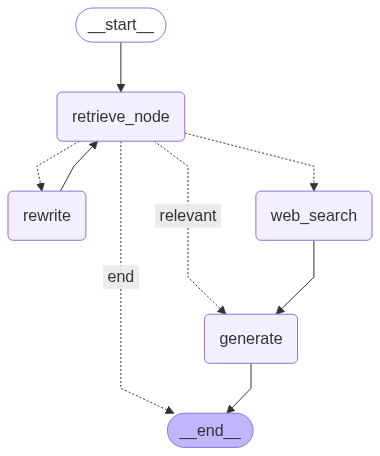

In [32]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [33]:
initial_state = {"query": "역삼역 맛집을 추천해주세요", "retry_count": 0}
graph.invoke(initial_state)

{'query': '"역삼역 인근 맛집 추천 부탁드립니다"',
 'context': [{'title': '역삼역 주변 맛집 리스트 - pangpang - 티스토리',
   'url': 'https://sam-repository.tistory.com/11',
   'content': '키워드: #한식 #뼈숯불구이 #감자탕 #양배추샐러드도맛도리 #많이매운편 #볶음밥도필수  \n도로명주소: 서울 강남구 테헤란로10길 21 1층  \n맛있게 먹은 사람: 73.77% (987 / 1338)  \n한 줄 평가:매운 음식을 좋아한다면 도전해볼만한 뼈숯불구이!  \n   \n매운 음식을 좋아한다면 신동궁감자탕 역삼직영점에서 매운 뼈숯불구이를 도전해보시는 건 어떨까요? 꽤 매운 편이라서 호불호가 갈릴 수 있으니 꼭! 매운 음식을 좋아하는 사람들이랑 가는 것을 추천드려요. 등뼈 사이사이에 낀 살이 부드럽게 발라지고, 중간중간 양배추 샐러드를 곁들여 먹거나 밥이랑 비벼 먹어도 좋아요. 다만 6시를 기준으로 사람들이 물밀 듯이 갈 수 있으니 웨이팅을 해야 할 수도 있습니다.\n\n이상으로 역삼역 주변 맛집 리스트를 정리해보았는데요, 이번 글을 읽고 역삼역 인근의 맛집을 찾는데 도움이 되셨으면 좋겠습니다! 이상 읽어주셔서 감사합니다. 😁😁 [...] 키워드: #한식 #만두전골 #손만두 #도가니수육 #예약필수 #술  \n도로명주소:  서울 강남구 언주로93길 22-3 지상 1층   \n맛있게 먹은 사람: 77.35% (239 / 309)  \n한 줄 평가: 손으로 직접 빚는 만두, 도가니 수육이 대박인 집!  \n   \n서울집은 손만두 전문점으로 따끈하게 쪄서 나오는 손만두와 양이 푸짐하고 쫄깃함이 일품인 도가니 수육이 맛있는 곳입니다. 역삼 인근에서 맛집으로 소문나서 예약을 하지 않고 방문 시 웨이팅을 해야 할 수도 있으니 가기 전에 예약하시는 걸 추천드려요! (저도 몇 번 그냥 갔다가 웨이팅 해야 했다는..) 특히 요즘 같이 쌀쌀한 날씨에 뜨끈~한 만두 전골에 도가니 수육까지 먹

In [34]:
initial_state = {"query": "소득이 5천만원인 거주자의 소득세를 알려주세요", "retry_count": 0}
graph.invoke(initial_state)

{'query': '소득이 5천만원인 거주자의 소득세를 알려주세요',
 'context': [Document(id='88337565-ab92-48d3-925f-e895647a45de', metadata={'source': './documents/income_tax.txt'}, page_content='② 제70조제1항, 제70조의2에 따른 제74조에 따라 차례로 할 것이 제70조제1항제2호에 따르며 서류를 제출하여야 한다는 경우에는 기준소득 중 거주자 본인이 된다(분산)과 제70조제2와 제74조에 따른 제료 및 제대법을 포함한다. 단, 차별제표청정인 그 업체를 남겨 제출한 경우로 그에 대하여 아니하다.<개정 2013. 1. 1.>\n  ③ 제80조에 따른 수익과 관련의 경우에는 기초공제 중 거주자 본인이 된다(분산)과 그에 관한 적지사항을 분명히 한다.\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제54조의2(공동사업에 대한 소득공제 등 특례) 제51조의3 또는 「조세특례제한법」에 따른 소득공제를 적용하거나 제59조의2에 따른 세액감면을 적용하는 경우 제54조제3항에 따라 공동사업자의 소득에 합산과세되는 특별세액거래의 지출․납입․투자 등의 금액이 있을 경우 주된 공동사업자의 소득에 합산과세되는 소득금액에 합산되어 주된 공동사업자의 합산과세세액은 공동사업소득액 또는 공동사업창출세액을 계산할 때 소득공제 또는 세액공제를 받을 수 있다. \n[개정 2014. 1. 1.]\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제2절 세액의 계산 <개정 2009. 12. 31.>\n제1관 세율 <개정 2009. 12. 31.>\n제55조(세율) 거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 "종합소득과세표준세액"이라 한다)을 그 세액으로 한다. <개정 2014. 1. 1., 2016. 12. 20., 2017. 12. 19., 2020. 12. 29., 2